データセットの用意

In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

Using TensorFlow backend.


平滑化

In [2]:
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

画像データの可視化

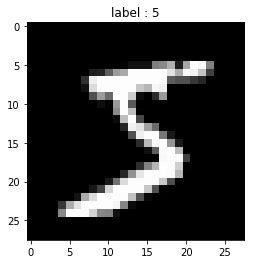

In [3]:
index = 0
image = X_train[index].reshape(28,28)
# X_train[index]: (784,)
# image: (28, 28)
plt.imshow(image, 'gray')
plt.title('label : {}'.format(y_train[index]))
plt.show()

[[-105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35
  -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35
  -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35
  -105.35]
 [-105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35
  -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35
  -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35
  -105.35]
 [-105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35
  -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35
  -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35
  -105.35]
 [-105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35
  -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35
  -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35
  -105.35]
 [-105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -1

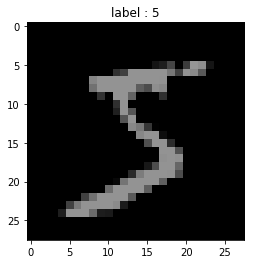

In [4]:
index = 0
image = X_train[index].reshape(28,28)
image = image.astype(np.float) # float型に変換
image -= 105.35 # 意図的に全体を負の数にする
#plt.imshow(image, 'gray')
plt.title('label : {}'.format(y_train[index]))
#plt.show()
print(image) # 値を確認
plt.imshow(image, 'gray', vmin = 0, vmax = 255)

前処理

In [5]:
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255
print(X_train.max()) # 1.0
print(X_train.min()) # 0.0

1.0
0.0


In [6]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])
print(y_train.shape) # (60000,)
print(y_train_one_hot.shape) # (60000, 10)
print(y_train_one_hot.dtype) # float64

(60000,)
(60000, 10)
float64


学習用データ6万枚の内2割を検証用データとして分割

In [7]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train_one_hot, test_size=0.1)
print(X_train.shape) # (48000, 784)
print(X_val.shape) # (12000, 784)

(54000, 784)
(6000, 784)


【問題1】ニューラルネットワーク分類器のクラスを作成

In [8]:
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      学習データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 10, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self.X = X[shuffle_index]
        self.y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)

    def __len__(self):
        return self._stop

    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self.X[p0:p1], self.y[p0:p1]        

    def __iter__(self):
        self._counter = 0
        return self

    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self.X[p0:p1], self.y[p0:p1]

In [12]:
class ScratchSimpleNeuralNetrowkClassifier():
    """
    シンプルな三層ニューラルネットワーク分類器

    Parameters
    ----------
    lr:学習率
    

    Attributes
    ----------
    """
    def __init__(self, epoch, batch_size, lr, n_features, n_nodes1, n_nodes2, n_output, sigma = 0.01):
        
        self.epoch = epoch
        self.batch_size = batch_size
        self.lr = lr
        self.n_features = n_features
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        self.n_output = n_output
        self.sigma = sigma     # ガウス分布の標準偏差
        # W, bの初期化
        self.W1 = self.sigma * np.random.randn(self.n_features, self.n_nodes1)
        self.b1 = self.sigma * np.random.randn(self.n_nodes1)[np.newaxis, :]
        self.W2 = self.sigma * np.random.randn(self.n_nodes1, self.n_nodes2)
        self.b2 = self.sigma * np.random.randn(self.n_nodes2)[np.newaxis, :]
        self.W3 = self.sigma * np.random.randn(self.n_nodes2, self.n_output)
        self.b3 = self.sigma * np.random.randn(self.n_output)[np.newaxis, :]
        
        self.losses = []
        self.val_losses = []
        
        
    def forward(self, X):
        
        # 1層目の実装
        A1 = np.dot(X, self.W1) + self.b1
        Z1 = self.tanh(A1)

        # 2層目の実装
        A2 = np.dot(Z1, self.W2) + self.b2
        Z2 = self.tanh(A2)

        # 3層目の実装
        A3 = np.dot(Z2, self.W3) + self.b3
        Z3 = self.softmax(A3)

        self.Z1 = Z1
        self.Z2 = Z2
        
        return Z3
    
    def sigmoid(self, X):
        
        return 1/1+np.exp(-X)
    
    def tanh(self, X):
        
        return (np.exp(X)-np.exp(-X)) / (np.exp(X)+np.exp(-X))
    
    #def softmax(self, X):
        #C = np.max(X)
       # z = X - C
       # Z = np.exp(z)/np.sum(np.exp(z), axis=1)[:,np.newaxis]
        #return Z
    def softmax(self, X):
        if X.ndim == 2:
            X = X.T
            X = X - np.max(X, axis=0)
            y = np.exp(X) / np.sum(np.exp(X), axis=0)
            return y.T
        X = X - np.max(X)
        return np.exp(X) / np.sum(np.exp(X), axis=1, keepdims=True)

    def relu(self, X):
        return np.max(0, X)
    
    def cross_entropy_error(self, y_pred, y):
        cross_entropy_error = np.sum(-y*np.log(y_pred),axis=1)
        
        return cross_entropy_error
    
    
    def derivative_closs_entropy_error_with_softmax(self, X, y):
        Z = self.forward(X)
        return Z - y
    
    def derivative_tanh(self, Z):
        
        return 1 - Z**2
    
    def derivative_sigmoid(self, Z):
        return Z*(1-Z)
    
    
    def back_propagation(self, X, y):
        grad = {}
        # backpropagation
        #1層目
        dout1 = self.derivative_closs_entropy_error_with_softmax(X, y) # Z3 - y
        grad_b3 = np.average(dout1)
        grad['b3'] = grad_b3
        grad_W3 = np.dot(self.Z2.T, dout1)
        grad['W3'] = grad_W3
        
        #2層目
        dout2 = (1-self.Z2**2)*np.dot(dout1, self.W3.T) # tanhの導関数
        grad_b2 = np.average(dout2)
        grad['b2'] = grad_b2
        grad_W2 = np.dot(self.Z1.T, dout2)
        grad['W2'] = grad_W2
        
        #3層目
        dout3 = (1-self.Z1**2)*np.dot(dout2, self.W2.T)
        grad_b1 = np.average(dout3)
        grad['b1'] = grad_b1
        grad_W1 = np.dot(X.T, dout3)
        grad['W1'] = grad_W1
        return grad

    def fit(self,X, y, X_val=None, y_val=None):
        """
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            学習用データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            学習用データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証用データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証用データの正解値
        """
        
        #batch_num = len(X_train)/self.batch_size
        #get_mini_batch = GetMiniBatch(X, y, self.batch_size, seed=10)
        
        # 学習
        for i in range(self.epoch):
            print('-----------------')
            print('epoch{}回目の学習'.format(i+1))
            get_mini_batch = GetMiniBatch(X, y, self.batch_size, seed=10)
            
            # minibatchのイテレーション
            for mini_X_train, mini_y_train in get_mini_batch:
                    
                # 更新
                grad = self.back_propagation(mini_X_train, mini_y_train)
                self.W1 -= self.lr * grad['W1']/self.batch_size
                self.b1 -= self.lr * grad['b1']/self.batch_size
                self.W2 -= self.lr * grad['W2']/self.batch_size
                self.b2 -= self.lr * grad['b2']/self.batch_size
                self.W3 -= self.lr * grad['W3']/self.batch_size
                self.b3 -= self.lr * grad['b3']/self.batch_size
                
            
            #1epoch毎のtrain_loss 重みは最後のミニバッチ
            y_hat = self.forward(X)
            epoch_loss = np.sum(self.cross_entropy_error(y_hat, y))/len(X)
            
            self.losses.append(epoch_loss)
            print('epoch_loss{}'.format(epoch_loss))
                
            if np.any(X_val):
                y_val_hat = self.forward(X_val)
                #1epoch毎のval_loss 重みは最後のミニバッチ
                epoch_val_loss = np.sum(self.cross_entropy_error(y_val_hat, y_val))/len(X_val) 
                #epoch_val_loss = np.sum(mini_val_loss)/batch_num/len(X_val) # 1epoch毎のval_loss
                self.val_losses.append(epoch_val_loss)
                print('epoch_val_loss{}'.format(epoch_val_loss))
            
    def predict(self, X_test):
        y_pred = self.forward(X_test)
        y_pred = np.argmax(y_pred, axis=1) # 確率の高いものをチョイス
        
        return y_pred
    
    def accuracy(self, X_test, y_test):
        y_pred = self.predict(X_test)
        accuracy = np.sum(y_pred==y_test)/len(y_test)
        
        return accuracy

In [13]:
three_layers = ScratchSimpleNeuralNetrowkClassifier(100, 50, 0.001, 784, 400, 200, 10)
three_layers.fit(X_train, y_train, X_val, y_val)

-----------------
epoch1回目の学習
epoch_loss2.299192689437871
epoch_val_loss2.2991541697896705
-----------------
epoch2回目の学習
epoch_loss2.296088009329582
epoch_val_loss2.2960589638247133
-----------------
epoch3回目の学習
epoch_loss2.2922421947926925
epoch_val_loss2.2922213330342003
-----------------
epoch4回目の学習
epoch_loss2.2870611190955747
epoch_val_loss2.287044398087391
-----------------
epoch5回目の学習
epoch_loss2.279528290015168
epoch_val_loss2.2795054358164633
-----------------
epoch6回目の学習
epoch_loss2.26772398232307
epoch_val_loss2.267669678642837
-----------------
epoch7回目の学習
epoch_loss2.247691190367685
epoch_val_loss2.2475411522339215
-----------------
epoch8回目の学習
epoch_loss2.2106338036993054
epoch_val_loss2.210214100029171
-----------------
epoch9回目の学習
epoch_loss2.136440460175037
epoch_val_loss2.1352480815867296
-----------------
epoch10回目の学習
epoch_loss1.9865995206573885
epoch_val_loss1.9832690377852207
-----------------
epoch11回目の学習
epoch_loss1.7491422739925113
epoch_val_loss1.7418581545285

epoch_loss0.3135368027611827
epoch_val_loss0.3179508899959195
-----------------
epoch90回目の学習
epoch_loss0.3122680930340915
epoch_val_loss0.31682456324157815
-----------------
epoch91回目の学習
epoch_loss0.3110083017691897
epoch_val_loss0.315705291184804
-----------------
epoch92回目の学習
epoch_loss0.30975700872876144
epoch_val_loss0.3145927111269333
-----------------
epoch93回目の学習
epoch_loss0.30851384541916504
epoch_val_loss0.3134865132294541
-----------------
epoch94回目の学習
epoch_loss0.30727849194331786
epoch_val_loss0.31238643711914454
-----------------
epoch95回目の学習
epoch_loss0.30605067387486595
epoch_val_loss0.3112922684943652
-----------------
epoch96回目の学習
epoch_loss0.3048301591379883
epoch_val_loss0.3102038357217173
-----------------
epoch97回目の学習
epoch_loss0.30361675488196804
epoch_val_loss0.30912100641771484
-----------------
epoch98回目の学習
epoch_loss0.30241030434467175
epoch_val_loss0.30804368401523313
-----------------
epoch99回目の学習
epoch_loss0.30121068370389126
epoch_val_loss0.306971804319270

【問題2】学習曲線のプロット

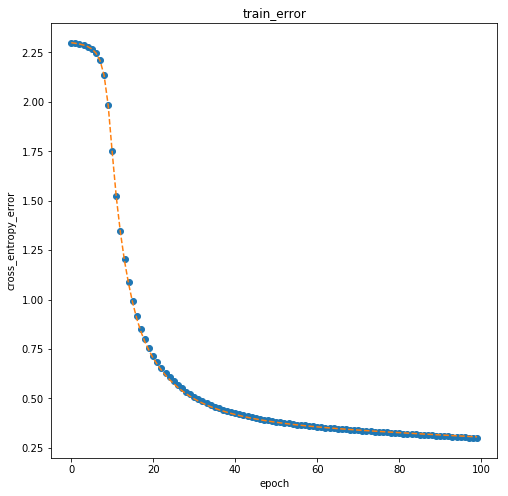

In [15]:
plt.figure(figsize=(8, 8))
plt.plot(three_layers.losses, 'o', label='train_loss')
plt.plot(three_layers.val_losses, '--', label='val_loss')
plt.title('train_error')
plt.xlabel('epoch')
plt.ylabel('cross_entropy_error')
plt.show()

In [17]:
three_layers.predict(X_test)

array([7, 2, 1, ..., 4, 5, 6], dtype=int64)

【問題3】指標値の算出

In [18]:
three_layers.accuracy(X_test, y_test)

0.9146